## Import the Dataset

In [ ]:
!curl -L -o /content/recipes.zip https://www.kaggle.com/api/v1/datasets/download/prashantsingh001/recipes-dataset-64k-dishes
!unzip /content/recipes.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 39.8M  100 39.8M    0     0  13.4M      0  0:00:02  0:00:02 --:--:-- 21.5M
Archive:  /content/recipes.zip
  inflating: 1_Recipe_csv.csv        
  inflating: 2_Recipe_json.json      


## Install Dependencies

In [ ]:
!pip install -U bitsandbytes accelerate transformers peft GPUtil

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 39.7 MB/s eta 0:00:00
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=27c256d55a4a7f2a4c00da5f4b24d5b69f4d540962e22f2c5eedc48c51c9291f
  Stored in directory: /root/.cache/pip/wheels/92/a8/b7/d8a067c31a74de9ca252bbe53dea5f896faabd25d55f541037
Successfully built GPUtil


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AutoModelForSequenceClassification, BitsAndBytesConfig, DistilBertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import copy
from peft import VeraConfig, get_peft_model, LoraConfig
import bitsandbytes as bnb
import gc
from sklearn.metrics import f1_score
import GPUtil


## Dataset Analysis
Cursory analysis of the dataset to identify what could be a classification target

Also only 10k rows are sampled to allow for an adequte training set while reducing the training times

In [ ]:

df = pd.read_csv('1_Recipe_csv.csv')
df = df.sample(n=10000, random_state=42).reset_index(drop=True)
print("=== Basic Info ===")
print(df.info())
print("\n=== Sunmmary Statistics ===")
print(df.describe())

=== Basic Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   recipe_title     10000 non-null  object
 1   category         10000 non-null  object
 2   subcategory      10000 non-null  object
 3   description      10000 non-null  object
 4   ingredients      10000 non-null  object
 5   directions       10000 non-null  object
 6   num_ingredients  10000 non-null  int64 
 7   num_steps        10000 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 625.1+ KB
None

=== Sunmmary Statistics ===
       num_ingredients     num_steps
count     10000.000000  10000.000000
mean          9.031100      4.684600
std           3.831632      2.299402
min           1.000000      1.000000
25%           6.000000      3.000000
50%           9.000000      4.000000
75%          11.000000      6.000000
max          28.000000     25.000000


In [ ]:
df.head()

,recipe_title,category,subcategory,description,ingredients,directions,num_ingredients,num_steps
0,Pound Cake with Lemon Coconut Glaze,Cakes,Coconut Cake,Healthier take on pound cake; indulge with no ...,"[""1 cup all-purpose flour"", ""3 tablespoons all...","[""Preheat the oven to 325 degrees F (165 degre...",12,8
1,Grandpa's Classic Coney Sauce,July 4Th,4Th Of July Side Dishes,Coney sauce is a condiment of ground beef simm...,"[""2 pounds ground beef"", ""\u00bd cup chopped o...","[""Gather the ingredients."", ""Place ground beef...",10,4
2,Air Fryer Baked Potatoes,Healthy Recipes,Low-Cholesterol Recipes,A baked potato in the air fryer comes out beau...,"[""2 large russet potatoes, scrubbed"", ""1 table...","[""Gather all ingredients and preheat an air fr...",3,3
3,Sauerkraut Onion Bread,Yeast Breads,Rye Bread,This recipe was sent to us by Dixie Matt who o...,"[""2 \u00bc cups bread flour"", ""1 cup milk"", ""\...","[""Add the ingredients to the bread pan in the ...",12,1
4,New Orleans Barbecue Shrimp,Mardi Gras,Mardi Gras Main Dishes,This New Orleans BBQ shrimp is a special entré...,"[""1 teaspoon garlic powder"", ""1 teaspoon onion...","[""In a small bowl, stir together garlic powder...",13,2


Graphing the numerical num_ingrediants to draw logical categories for the classes

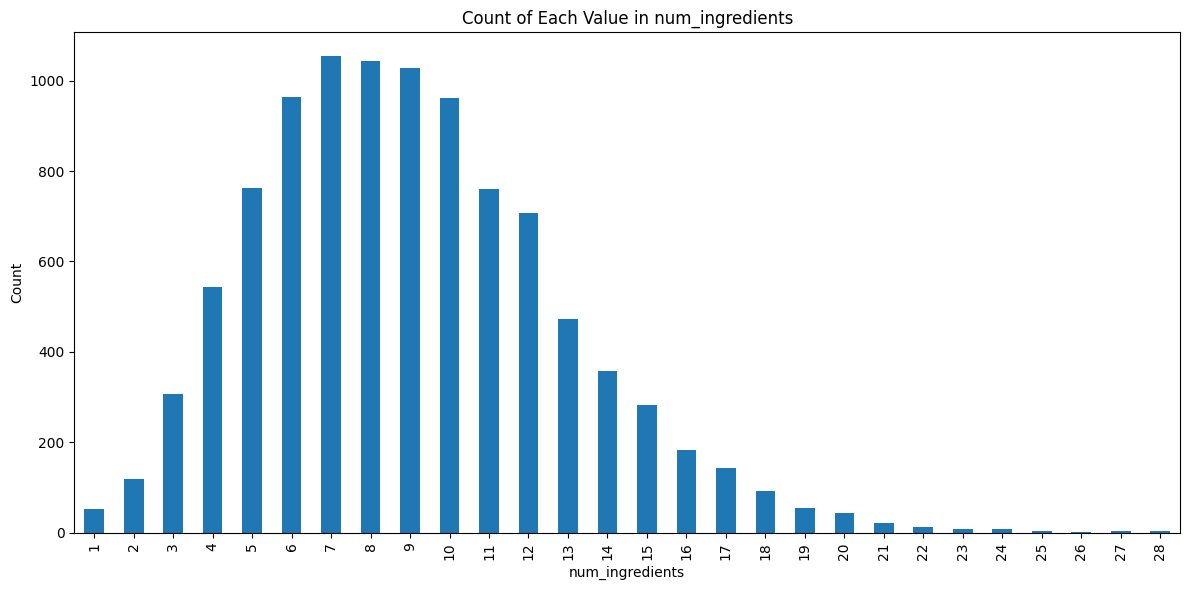

In [ ]:

cols = ['num_ingredients']
plt.figure(figsize=(12, 6))

for i, col in enumerate(cols, 1):
    plt.subplot(1, len(cols), i)
    df[col].value_counts().sort_index().plot(kind='bar')
    plt.title(f"Count of Each Value in {col}")
    plt.xlabel(col)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()



## Set Labels for Classification Model

In [ ]:
def label_recipe(num_ingredients):
  if num_ingredients <= 6:
    return 'Student'
  if num_ingredients <=10:
    return 'Regular'
  else:
    return 'Complex'

In [ ]:
df['recipe_level'] = df.apply(lambda row: label_recipe(row.num_ingredients), axis=1)

In [ ]:
# Create an label encoder based off the unique values in recipe_level, done this way to be dynamic if more categories are added
label_encoder = LabelEncoder()
df["recipe_level_encoded"] = label_encoder.fit_transform(df["recipe_level"])

# Split into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["directions"].values, df["recipe_level_encoded"].values,
    test_size=0.2, random_state=42,)

## Create loader

In [ ]:
# Pull a tokeniser down based on our base model
tokenizer = BertTokenizer.from_pretrained("distilbert-base-uncased")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [ ]:
# A classifier class to work with the bath loader, it is needed to convert the
# base description into tokens with encoding with the correct label attached per
# item
class ClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long),
        }



## Model Training Loop

In [ ]:
def measure_gpu_usage(device="cuda"):
    torch.cuda.synchronize()
    gc.collect()
    torch.cuda.empty_cache()

    allocated = torch.cuda.memory_allocated(device) / (1024 ** 3)
    reserved = torch.cuda.memory_reserved(device) / (1024 ** 3)
    gpu_info = GPUtil.getGPUs()[0]
    gputil_used = gpu_info.memoryUsed / 1024

    return gputil_used

In [ ]:
def train_model(model_train, epochs, fine_tune_type, optimizer, train_loader):

  fine_tune_start = time.perf_counter()
  #Return early if on CPU (Not worth it)
  if torch.cuda.is_available():
      torch.cuda.reset_peak_memory_stats(device)
  else:
    return

  total_avg_memory_use = []
  for epoch in range(epochs):
      # Set model into training mode
      model_train.train()
      total_loss = 0
      # Create a loading loop to loop through the total dataset in batches
      loop = tqdm(train_loader, leave=True)
      for batch in loop:
          #Stop accumalted gradients from older batches
          optimizer.zero_grad()

          #Move inputs to GPU
          input_ids = batch["input_ids"].to(device)
          attention_mask = batch["attention_mask"].to(device)
          labels = batch["label"].to(device)


          #Forward pass of the model
          outputs = model_train(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
          loss = outputs.loss
          total_loss += loss.item()

          #Calculate gradients (Autodiff)
          loss.backward()

          #Clip gradients to remove risk of exploding gradients
          torch.nn.utils.clip_grad_norm_(model_train.parameters(), 1.0)

          #Backpropagation of weights update
          optimizer.step()


          loop.set_description(f"Epoch {epoch}")
          loop.set_postfix(loss=loss.item())

      print(f"Epoch {epoch} Loss: {total_loss / len(train_loader)}")
      gpu_mem = measure_gpu_usage()
      total_avg_memory_use.append(gpu_mem)
      max_mem_allocated = torch.cuda.max_memory_allocated(device) / (1024 ** 3)

  fine_tune_end = time.perf_counter()
  fine_tune_time = fine_tune_end - fine_tune_start
  print(f"Ran the model in {fine_tune_time} seconds")
  Model_train_time[fine_tune_type] = fine_tune_time
  Model_trained_params[fine_tune_type] = sum(p.numel() for p in model_train.parameters() if p.requires_grad)
  Model_trained_memory_use[fine_tune_type] = sum(total_avg_memory_use) / len(total_avg_memory_use)

  # final peak memory usage
  if torch.cuda.is_available():
      peak_mem = torch.cuda.max_memory_allocated(device) / (1024 ** 3)
      print(f"Peak GPU memory used during training: {peak_mem:.2f} GB")

## Model Evaluation

Evaluation for f1 score and accuracy of the model

In [ ]:
def eval_model(model, val_loader, fine_tune_type):
  model.eval()
  correct = 0
  total = 0

  all_labels = []
  all_predictions = []

  with torch.no_grad():
      for batch in val_loader:
          input_ids = batch["input_ids"].to(device)
          attention_mask = batch["attention_mask"].to(device)
          labels = batch["label"].to(device)


          outputs = model(input_ids=input_ids, attention_mask=attention_mask)
          #Calculate predictions based logits
          predictions = torch.argmax(outputs.logits, dim=1)

          correct += (predictions == labels).sum().item()
          total += labels.size(0)

          # Store for confusion matrix
          all_labels.extend(labels.cpu().numpy())
          all_predictions.extend(predictions.cpu().numpy())

  accuracy = correct / total
  Model_trained_accuracy[fine_tune_type] = accuracy
  print(f"Validation Accuracy: {accuracy:.4f}")

  f1score = f1_score(all_labels, all_predictions, average="weighted")
  Model_trained_f1_score[fine_tune_type] = f1score

  cm = confusion_matrix(all_labels, all_predictions)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot(cmap="Blues", values_format="d")
  plt.title("Confusion Matrix")
  plt.show()

## Loader Initialisation Helper

In [ ]:
def init_loader(max_len, batch_size):
  #Put train test split dataset into the wrapper class
  train_dataset = ClassificationDataset(train_texts, train_labels, tokenizer, max_len)
  val_dataset = ClassificationDataset(val_texts, val_labels, tokenizer, max_len)

  # Create DataLoaders for the batch looping
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
  return train_loader,val_loader

In [ ]:
def count_parameters(model):
  bytes_per_param = next(model.parameters()).element_size()
  total_params = sum(p.numel() for p in model.parameters())
  trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  bytes_per_param = next(model.parameters()).element_size()

  print(f"Total params: {total_params:,}")
  print(f"Trainable params: {trainable_params:,}")
  print(f"Model size (all): {total_params * bytes_per_param / 1e6:.2f} MB")
  print(f"Trainable only: {trainable_params * bytes_per_param / 1e6:.2f} MB")
  print(f"Percentage trainable: {100 * trainable_params / total_params:.2f}%")

## Device Setup

In [ ]:
# Model and Device Setup
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
elif hasattr(torch, "xpu") and torch.xpu.is_available():
    device = torch.device("xpu")
else:
    device = torch.device("cpu")


## Global Variables

In [ ]:
# Monitoring Variables
Model_train_time = {}
Model_trained_params = {}
Model_trained_accuracy = {}
Model_trained_memory_use = {}
Model_trained_f1_score = {}

max_len = 256
epochs = 6

## Base Model Initialisation

In [ ]:
base_model = DistilBertForSequenceClassification.from_pretrained( "distilbert-base-uncased",
                                 num_labels=len(label_encoder.classes_))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Base Fine Tuning Model

In [ ]:
model = copy.deepcopy(base_model)
#Params are token input length and batch size
train_loader_ft, val_loader_ft = init_loader(max_len, 16)
count_parameters(model)

Total params: 66,955,779
Trainable params: 66,955,779
Model size (all): 267.82 MB
Trainable only: 267.82 MB
Percentage trainable: 100.00%


Epoch 0: 100%|██████████| 500/500 [01:01<00:00,  8.13it/s, loss=0.654]


Epoch 0 Loss: 0.7358328953683376


Epoch 1: 100%|██████████| 500/500 [01:01<00:00,  8.09it/s, loss=0.328]


Epoch 1 Loss: 0.5193573810607195


Epoch 2: 100%|██████████| 500/500 [01:01<00:00,  8.12it/s, loss=0.292]


Epoch 2 Loss: 0.41236863128095863


Epoch 3: 100%|██████████| 500/500 [01:01<00:00,  8.11it/s, loss=0.579]


Epoch 3 Loss: 0.2992567280288786


Epoch 4: 100%|██████████| 500/500 [01:01<00:00,  8.12it/s, loss=0.0699]


Epoch 4 Loss: 0.2232485524462536


Epoch 5: 100%|██████████| 500/500 [01:01<00:00,  8.07it/s, loss=0.372]


Epoch 5 Loss: 0.1665982916445937
Ran the model in 372.33775759300005 seconds
Peak GPU memory used during training: 3.08 GB
Validation Accuracy: 0.8420


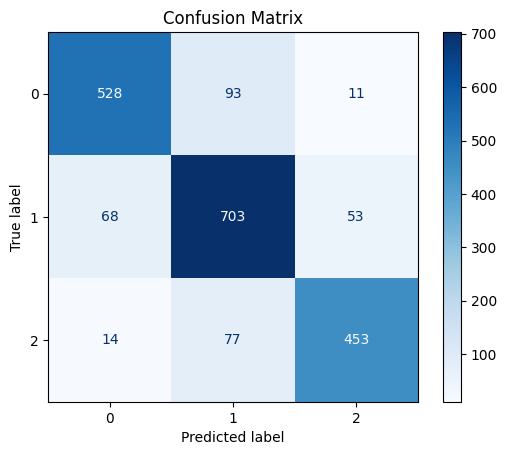

In [ ]:

model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)
train_model(model, epochs, 'FineTune', optimizer, train_loader_ft)
eval_model(model, val_loader_ft, 'FineTune')
del model, optimizer

## Lora Model Initialisation

In [ ]:
lora_base = copy.deepcopy(base_model)
train_loader_lora, val_loader_lora = init_loader(max_len, 16)

# Target modules q_lin and v_lin are needed as they are the modules distilbert use
# Rank corresponds to the size of the low rank matrices
config = LoraConfig(r=64, lora_dropout=0.05, target_modules=["q_lin", "v_lin"])
lora_model = get_peft_model(lora_base, config)
for param in lora_model.base_model.model.classifier.parameters():
    param.requires_grad = True
count_parameters(lora_model)

Total params: 68,135,427
Trainable params: 1,181,955
Model size (all): 272.54 MB
Trainable only: 4.73 MB
Percentage trainable: 1.73%


Epoch 0: 100%|██████████| 500/500 [00:49<00:00, 10.10it/s, loss=0.485]


Epoch 0 Loss: 0.7664433175325394


Epoch 1: 100%|██████████| 500/500 [00:49<00:00, 10.09it/s, loss=0.703]


Epoch 1 Loss: 0.5984022476375103


Epoch 2: 100%|██████████| 500/500 [00:49<00:00, 10.10it/s, loss=0.425]


Epoch 2 Loss: 0.5367652032673359


Epoch 3: 100%|██████████| 500/500 [00:49<00:00, 10.10it/s, loss=0.52]


Epoch 3 Loss: 0.4956577834188938


Epoch 4: 100%|██████████| 500/500 [00:49<00:00, 10.10it/s, loss=0.241]


Epoch 4 Loss: 0.45385980522632596


Epoch 5: 100%|██████████| 500/500 [00:49<00:00, 10.12it/s, loss=0.304]


Epoch 5 Loss: 0.43646370857954025
Ran the model in 299.32972126799996 seconds
Peak GPU memory used during training: 2.32 GB
Validation Accuracy: 0.7930


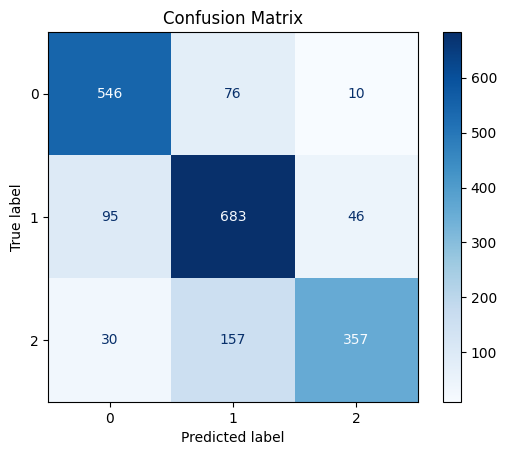

In [ ]:

lora_model.to(device)

lora_optimizer = AdamW(lora_model.parameters(), lr=5e-4)
train_model(lora_model, epochs, 'Lora', lora_optimizer, train_loader_lora)
eval_model(lora_model, val_loader_lora, 'Lora')
del lora_model, lora_optimizer

## Vera Fine Tuning

In [ ]:
vera_base = copy.deepcopy(base_model)
train_loader_vera, val_loader_vera = init_loader(max_len, 16)
config = VeraConfig(
    r=64,vera_dropout=0.05, target_modules=["q_lin", "v_lin"]
)
vera_model = get_peft_model(vera_base, config)
for param in vera_model.base_model.model.classifier.parameters():
    param.requires_grad = True

count_parameters(vera_model)

Total params: 66,965,763
Trainable params: 12,291
Model size (all): 267.86 MB
Trainable only: 0.05 MB
Percentage trainable: 0.02%


Epoch 0: 100%|██████████| 500/500 [00:49<00:00, 10.16it/s, loss=0.76]


Epoch 0 Loss: 1.0111982082128526


Epoch 1: 100%|██████████| 500/500 [00:49<00:00, 10.19it/s, loss=0.665]


Epoch 1 Loss: 0.7862820693254471


Epoch 2: 100%|██████████| 500/500 [00:49<00:00, 10.19it/s, loss=0.64]


Epoch 2 Loss: 0.7068366226553917


Epoch 3: 100%|██████████| 500/500 [00:49<00:00, 10.10it/s, loss=0.682]


Epoch 3 Loss: 0.6637338749170303


Epoch 4: 100%|██████████| 500/500 [00:49<00:00, 10.13it/s, loss=0.801]


Epoch 4 Loss: 0.6466994759738445


Epoch 5: 100%|██████████| 500/500 [00:49<00:00, 10.15it/s, loss=0.378]


Epoch 5 Loss: 0.6185713138282299
Ran the model in 297.84209421000014 seconds
Peak GPU memory used during training: 2.58 GB
Validation Accuracy: 0.7275


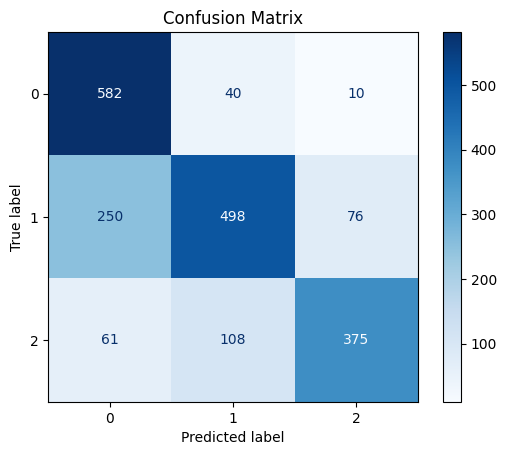

In [ ]:
vera_model.to(device)

vera_optimizer = AdamW(vera_model.parameters(), lr=1e-3)
train_model(vera_model, epochs, 'Vera', vera_optimizer, train_loader_vera)
eval_model(vera_model, val_loader_vera, 'Vera')
del vera_optimizer, vera_model

## QLora Initialisation

In [ ]:
# config to use 4-bit quantization with BitsAndBytes
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4", # 4-bit NormalFloat (NF4) quantization
    bnb_4bit_compute_dtype=torch.bfloat16 # computation done in bfloat16
)

qlora_model = copy.deepcopy(base_model)
train_loader_qlora, val_loader_qlora = init_loader(max_len, 16)

config = LoraConfig(
    r=64,
    lora_alpha=32,
    target_modules=["q_lin", "v_lin"],
    lora_dropout=0.05,
    bias="none"
)

qlora_model = get_peft_model(qlora_model, config)
for param in qlora_model.classifier.parameters():
    param.requires_grad = True
count_parameters(qlora_model)

Total params: 68,135,427
Trainable params: 1,181,955
Model size (all): 272.54 MB
Trainable only: 4.73 MB
Percentage trainable: 1.73%


Epoch 0: 100%|██████████| 500/500 [00:49<00:00, 10.13it/s, loss=0.663]


Epoch 0 Loss: 0.7476776459813118


Epoch 1: 100%|██████████| 500/500 [00:49<00:00, 10.14it/s, loss=0.919]


Epoch 1 Loss: 0.5978290819227695


Epoch 2: 100%|██████████| 500/500 [00:49<00:00, 10.10it/s, loss=0.511]


Epoch 2 Loss: 0.5260722005963325


Epoch 3: 100%|██████████| 500/500 [00:49<00:00, 10.17it/s, loss=0.598]


Epoch 3 Loss: 0.469399608194828


Epoch 4: 100%|██████████| 500/500 [00:49<00:00, 10.19it/s, loss=0.222]


Epoch 4 Loss: 0.43039176788926126


Epoch 5: 100%|██████████| 500/500 [00:49<00:00, 10.17it/s, loss=0.732]


Epoch 5 Loss: 0.38590448737889527
Ran the model in 297.852040388 seconds
Peak GPU memory used during training: 2.85 GB
Validation Accuracy: 0.7835


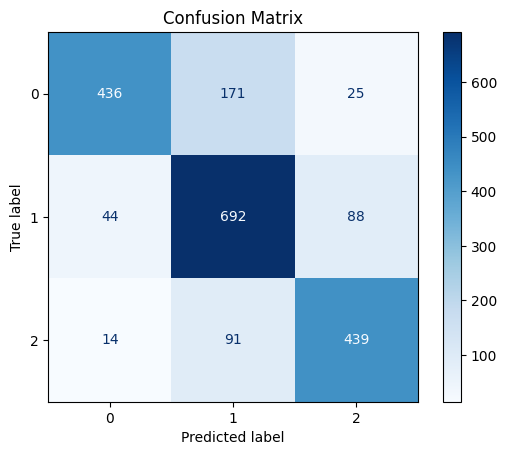

In [ ]:
qlora_model.to(device)

qlora_optimizer = AdamW(qlora_model.parameters(), lr=5e-4)
train_model(qlora_model, epochs, 'QLora', qlora_optimizer, train_loader_qlora)
eval_model(qlora_model, val_loader_qlora, 'QLora')
del qlora_optimizer, qlora_model

## Results Plotting

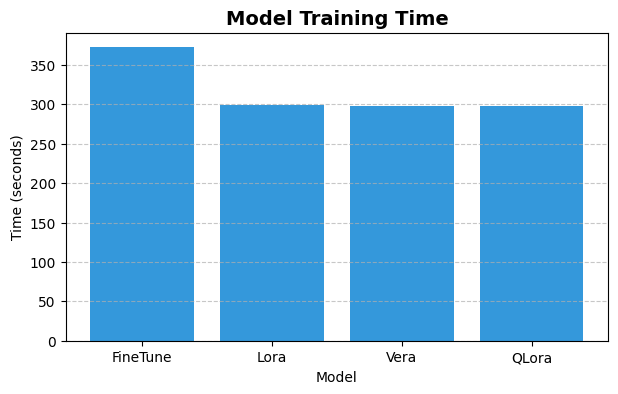

In [ ]:
# Set style
plt.style.use("seaborn-v0_8-deep")

# Helper function for consistent plotting
def plot_metric(data_dict, title, ylabel, color):
    plt.figure(figsize=(7, 4))
    plt.bar(data_dict.keys(), data_dict.values(), color=color)
    plt.title(title, fontsize=14, weight="bold")
    plt.ylabel(ylabel)
    plt.xlabel("Model")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Plot each metric separately
plot_metric(Model_train_time, "Model Training Time", "Time (seconds)", "#3498db")

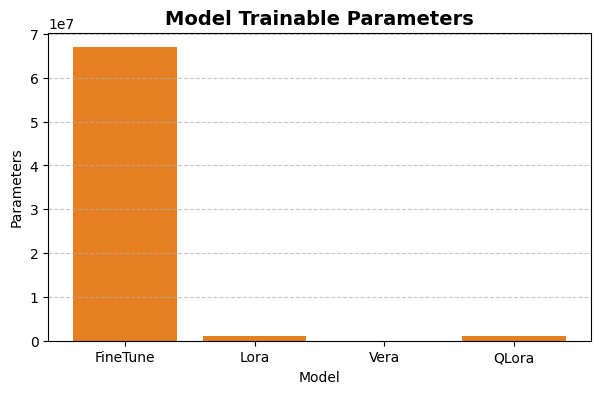

In [ ]:
plot_metric(Model_trained_params, "Model Trainable Parameters", "Parameters", "#e67e22")

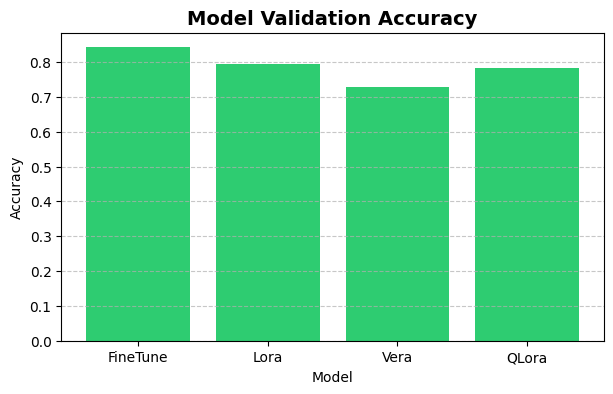

In [ ]:
plot_metric(Model_trained_accuracy, "Model Validation Accuracy", "Accuracy", "#2ecc71")

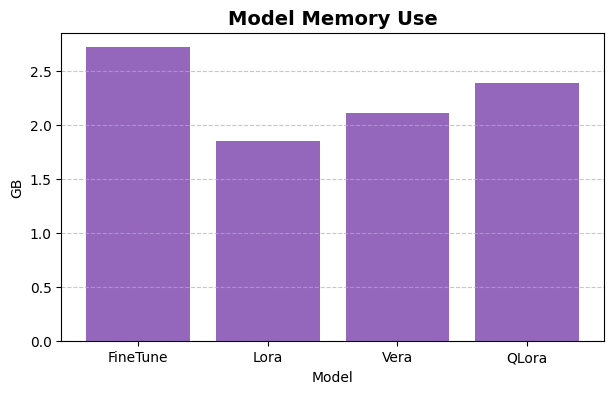

In [ ]:
plot_metric(Model_trained_memory_use, "Model Memory Use", "GB", "#9467bd")

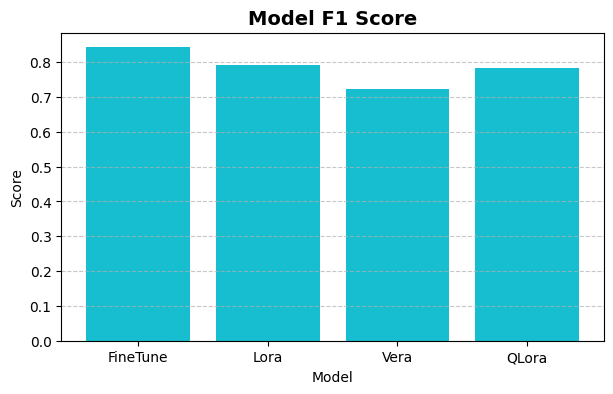

In [ ]:
plot_metric(Model_trained_f1_score, "Model F1 Score", "Score", "#17becf")